# CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [0]:
# ! pip install tensorflow==1.13.1

In [0]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense,AveragePooling2D,BatchNormalization,Conv2D,Input,Flatten,Activation,concatenate,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
num_filter = 12
compression = 0.5

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
# from sklearn.model_selection import train_test_split
# from sklearn.utils import resample
# X_train,y_train = resample(X_train,y_train,n_samples = 30000)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=5/30, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=5/25, random_state=42)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=10/50, random_state=42)

In [0]:
# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_cv = tf.keras.utils.to_categorical(y_cv, num_classes)

In [7]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape,y_cv.shape)

(40000, 32, 32, 3) (40000, 10)
(10000, 32, 32, 3) (10000, 10)
(10000, 32, 32, 3) (10000, 10)


## Model Architechture

Implemented **DenseNet-BC(k= 12, L = 100) with 0.76M parameters** with cifar-10 using augmentation.

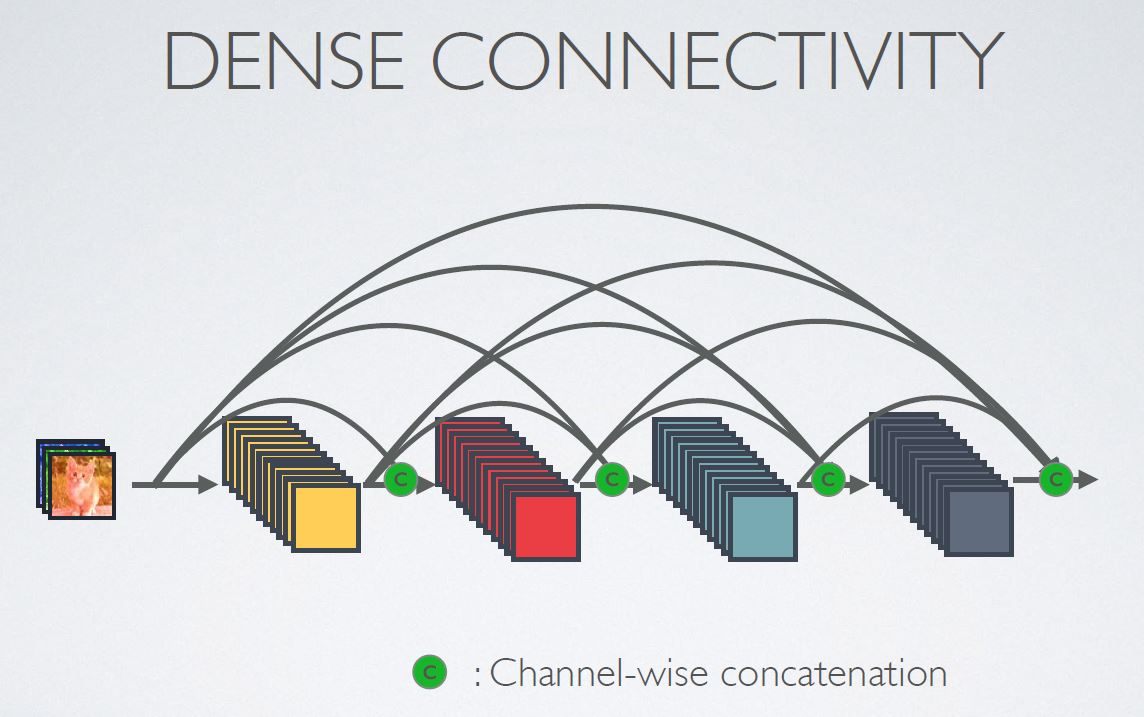

In [0]:
class Convolution():
    '''
    Before entering the first dense vlock, a convolution with 16 (or twice the 
    growth rate for BC type) output channels is performed on the input images
    '''
    def __init__(self, growthRate = 12, weight_decay=1E-4):
        self.growthRate = growthRate
        self.weight_decay = weight_decay
        
    def __call__(self, x):
        
        #x = Activation('relu')(x)
        op = Conv2D(int(2*self.growthRate),3,padding="same",use_bias=False,bias_initializer='zeros',kernel_regularizer=l2(self.weight_decay))(x)
        
        return op

In [9]:
# test code
in_ = Input(shape=(32,32,3))
op = Convolution()(in_)
print(op.shape)

W0813 16:36:52.858003 140186611292032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(?, 32, 32, 24)


### Class BottleNeck

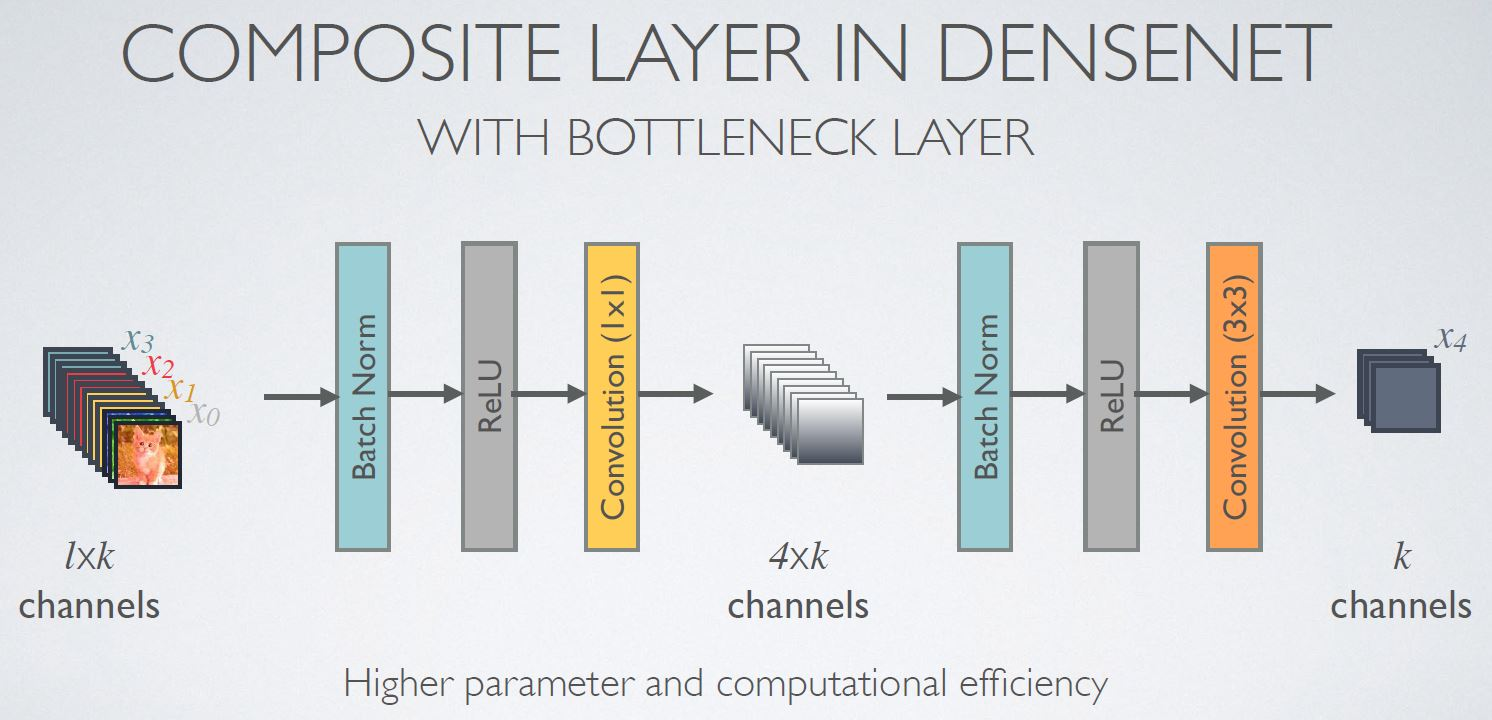

In [0]:
class Bottelneck():
    """
    This class implements H(l) as mentioned in paper.
    BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3) version of H.
    """
    
    def __init__(self,growthrate = 12,weight_decay=1E-4):
        
        self.growthrate = growthrate
        self.weight_decay = weight_decay
        
        
    def __call__(self,x):
        """
        This is where logic lives.
        """
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(4*self.growthrate),1,padding="same",use_bias=False,kernel_initializer="he_uniform",kernel_regularizer=l2(self.weight_decay))(x)
        
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(self.growthrate),3,padding="same",use_bias=False,kernel_initializer="he_uniform",kernel_regularizer=l2(self.weight_decay))(x)
        
        return x

### Class Transition

In [0]:
class Transition():
    """
    This class implements transition layer as per paper.
    BN-Con-pooling
    """  
    def __init__(self,compression = 0.5,growthrate = 12,weight_decay=1E-4):
        
        self.compression = compression
        self.growthrate = growthrate
        self.weight_decay = weight_decay
        
    def __call__(self,x):
        
        nChannels = x.shape.as_list()[-1]
        
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(self.compression * nChannels),1,padding="same",use_bias=False,kernel_regularizer=l2(self.weight_decay))(x)
        x = AveragePooling2D(pool_size=(2,2))(x)
        
        return x

### Class DenseNet

In [0]:
class Densenet():
    """
    This layer implements densenet.
    """
    def __init__(self,depth,growthrate = 12,bottleneck = True):
        
        nDenseLayers = (depth-4) // 3
        if bottleneck:
            nDenseLayers //= 2
        
        self.nDenseLayers = nDenseLayers
        self.growthrate = growthrate
        
            
    def __call__(self,x):
        
        # Dense Block logic
        
        # convolution block
        x = Convolution()(x)
        
        # 1st dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])
            
        # transition layer
        x = Transition()(x)
            
        # 2nd dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])
            
        # transition layer
        x = Transition()(x)

        # 3rd dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])

        return x

### Class Output

In [0]:
class Output():
    """
    This layer implements output layer.
    """
    
    def __init__(self,num_classes = 10,weight_decay=1E-4):
        
        self.num_classes = num_classes
        self.weight_decay = weight_decay
        
    def __call__(self,x):
      
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = GlobalAveragePooling2D()(x)
        #avg = AveragePooling2D(pool_size=(8,8))(x)
        #flt = Flatten()(avg)
        op = Dense(self.num_classes,activation="softmax",kernel_regularizer=l2(self.weight_decay), bias_regularizer=l2(self.weight_decay))(x)
        
        return op

### Model Building

In [0]:
# # The DenseNet used in our experiments has three dense blocks that each has an equal number of layers.

# 

# # First convolution
# cnv = Convolution()(in_)

# # For dense block  1
# op = Densenet(depth=100)(cnv)
# op = Transition()(op)

# # For dense block  2
# op = Densenet(depth=100)(op)
# op = Transition()(op)


in_ = Input(shape=(32,32,3))

# densenet
op = Densenet(100)(in_)

# output 
op = Output()(op)

In [0]:
model = Model(inputs = in_,outputs = op)
sgd = tf.keras.optimizers.SGD(lr = 0.1,momentum = 0.9,nesterov = True)
model.compile(sgd,loss="categorical_crossentropy",metrics=["acc"])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# sgd = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True)

# from sklearn.metrics import roc_auc_score
# # https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    
# def auroc(y_true, y_pred):
#     return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
#callbacks
from time import time
from datetime import datetime


from tensorflow.python.keras.callbacks import TensorBoard

filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
history = tf.keras.callbacks.History()

# tensorboard
tensorboard = TensorBoard(log_dir="model_logs/{}".format(time()))

filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpoint_save = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_save,learning_rate_reduction,history,tensorboard]

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.3,
    rotation_range=15,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='nearest')

cv_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [0]:
train_datagen.fit(X_train)
cv_datagen.fit(X_cv)
test_datagen.fit(X_test)

In [0]:
# # using tensorboard instance for callbacks
# from time import time
# from datetime import datetime
# from tensorflow.python.keras.callbacks import TensorBoard

# filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
# history = tf.keras.callbacks.History()

# # tensorboard
# tensorboard = TensorBoard(log_dir="model_logs/{}".format(time()))

# # best model saving
# model_check = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# # reduce learning rate
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.0001)

W0813 09:44:20.662464 139758047876992 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [0]:
epochs = 100
batch_size = 64
val_batch_size = 64
steps = len(y_train)//batch_size
val_steps = len(y_cv)//val_batch_size

In [23]:
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=64),steps_per_epoch=steps,
                    epochs=100,callbacks=callbacks_list,
                    validation_data=cv_datagen.flow(X_cv,y_cv,batch_size=64),validation_steps = val_steps)

Epoch 1/100
624/625 [============================>.] - ETA: 0s - loss: 3.2604 - acc: 0.4124
Epoch 00001: val_acc improved from -inf to 0.38642, saving model to weights.01-3.60.hdf5
625/625 [==============================] - 226s 362ms/step - loss: 3.2598 - acc: 0.4125 - val_loss: 3.6044 - val_acc: 0.3864
Epoch 2/100
624/625 [============================>.] - ETA: 0s - loss: 2.4873 - acc: 0.5839
Epoch 00002: val_acc improved from 0.38642 to 0.48528, saving model to weights.02-2.66.hdf5
625/625 [==============================] - 159s 255ms/step - loss: 2.4870 - acc: 0.5839 - val_loss: 2.6554 - val_acc: 0.4853
Epoch 3/100
624/625 [============================>.] - ETA: 0s - loss: 2.0091 - acc: 0.6760
Epoch 00003: val_acc improved from 0.48528 to 0.57592, saving model to weights.03-2.20.hdf5
625/625 [==============================] - 160s 256ms/step - loss: 2.0088 - acc: 0.6762 - val_loss: 2.1968 - val_acc: 0.5759
Epoch 4/100
624/625 [============================>.] - ETA: 0s - loss: 1.700

KeyboardInterrupt: ignored

In [0]:
# https://stackoverflow.com/questions/50127257/is-there-any-way-to-stop-training-a-model-in-keras-after-a-certain-accuracy-has

# callbacks = [
#     EarlyStoppingByAccuracy(monitor='accuracy', value=0.98, verbose=1),
#     ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
# ]
# model.fit(X_train.astype('float32'), Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
#       shuffle=True, verbose=1, validation_data=(X_valid, Y_valid),
#       callbacks=callbacks)

## Loss And Accuracy Plots

#### Download tensorboard logs

In [36]:
!zip -r /content/logs.zip /content/model_logs

  adding: content/model_logs/ (stored 0%)
  adding: content/model_logs/1565714363.7803748/ (stored 0%)
  adding: content/model_logs/1565714363.7803748/train/ (stored 0%)
  adding: content/model_logs/1565714363.7803748/train/events.out.tfevents.1565714551.4683528c7227.137.14507.v2 (deflated 95%)
  adding: content/model_logs/1565714363.7803748/validation/ (stored 0%)
  adding: content/model_logs/1565714363.7803748/validation/events.out.tfevents.1565714781.4683528c7227.137.28198.v2 (deflated 65%)


In [42]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-08-13 20:42:35--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.237.103, 52.45.111.123, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.237.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  31.6MB/s    in 0.4s    

2019-08-13 20:42:35 (31.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = '/content/model_logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

In [45]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://aacd44cd.ngrok.io


### Train and Test Loss 

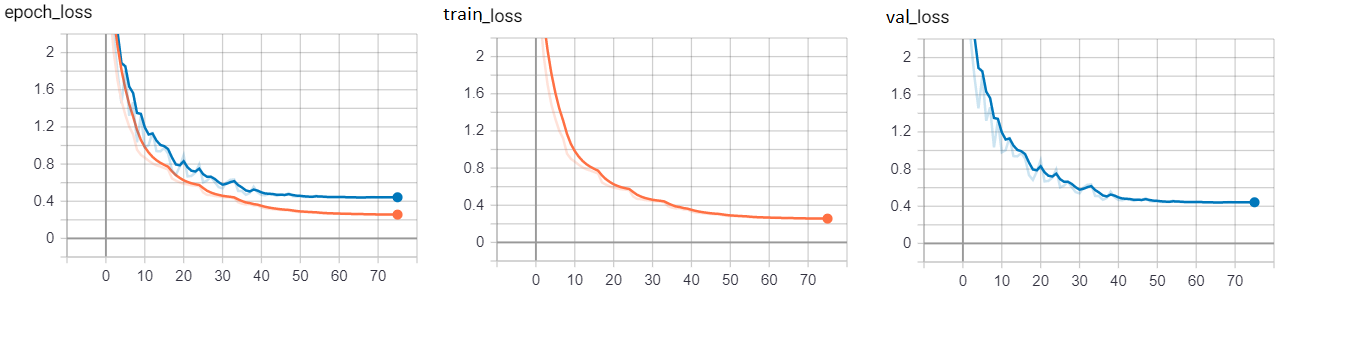

### Train and Test Accuracy

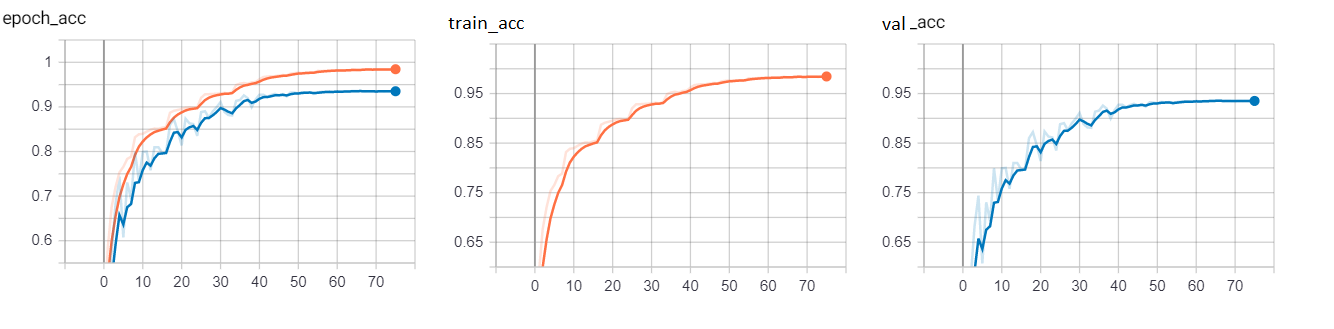

## Test Accuracy

In [24]:
# evaluate on test data
score = model.evaluate_generator(test_datagen.flow(X_test, y_test, batch_size=64), verbose=1)

157/157 [==============================] - 10s 64ms/step - loss: 0.4492 - acc: 0.9269


In [25]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4492105321519694
Test accuracy: 0.9269


## Confusion Matrix

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
import numpy as np
# Predict the values from the validation dataset
X_test = X_test.astype('float32')
X_test /= 255

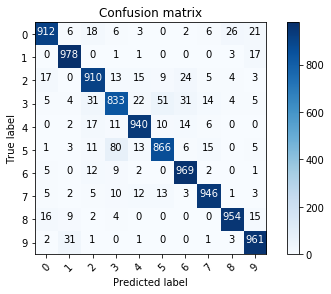

In [34]:
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


## Heat Map

10000/10000 - 8s


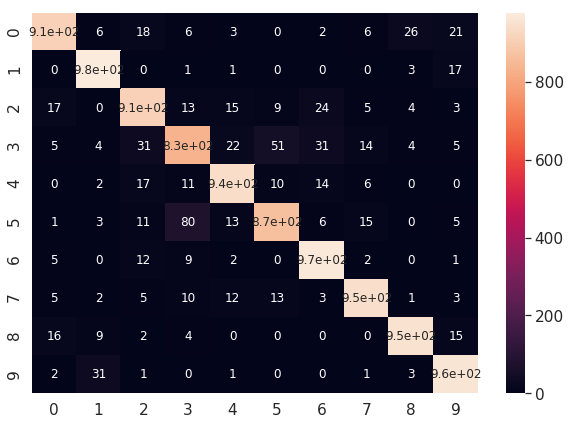

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
Y_pred = model.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
cm = confusion_matrix(np.argmax(y_test,axis=1),
                      y_pred)
import seaborn as sn
import pandas  as pd
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size